# Simulating lightcurves for SNe Ia
This notebook uses a simple one observations per night cadence to determine what the minimum requirement for SNe Ia is.

In [20]:
import os
home_dir = os.environ.get('HOME')

# Please make sure that the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# is correct. The example assumes they are in a folder 'data/sfd98' inside your home directory.
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

/home/ufein
/home/ufein/data/sfd98


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey

import simsurvey_tools as sst

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
ccd_corners = np.genfromtxt('data/ZTF_corners.txt')
ccds = [ccd_corners[4*k+16:4*k+20] for k in range(16)]

In [4]:
mjd_range = (58000, 58365)

plan = sst.get_survey_plan_nday({'desg': (3,0), 'desr': (3,0), 'desi': (5,0)},
                                mjd_range=mjd_range,
                                skynoise={'desg': 800., 'desr': 800., 'desi': 1260.},
                                ccds=ccds)

In [9]:
tr = simsurvey.get_sn_generator([0.,0.2], ratekind="basic", 
                                dec_range=[-30,90],
                                mjd_range=[mjd_range[0] - 60, mjd_range[-1] + 24],
                                sfd98_dir=sfd98_dir)

In [10]:
instprop = {"desg":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desi":{"gain":1.,"zp":30,"zpsys":'ab'}}

survey = simsurvey.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

lcs = survey.get_lightcurves(
    progress_bar=True # If you get an error because of the progress_bar, delete this line.
)

In [11]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys,field,ccd
float64,str4,float64,float64,int64,str2,int64,int64
58132.0427083,desg,-995.127449113,800.029897486,30,ab,489,6
58132.0427083,desr,976.110760837,800.105501626,30,ab,489,6
58135.0421875,desg,1334.40890686,800.476390865,30,ab,489,6
58135.0421875,desi,500.39623456,1260.38518048,30,ab,489,6
58135.0421875,desr,707.287332207,800.538885428,30,ab,489,6
58138.0411458,desg,2558.77766045,801.230739277,30,ab,489,6
58138.0411458,desr,1674.45294678,801.22583068,30,ab,489,6
58140.0359375,desi,4023.18081886,1261.20506288,30,ab,489,6
58141.0395833,desg,4993.28492678,802.31070242,30,ab,489,6


## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Below are some examples how to assess survey statistics based on this.

The first skyplot shows all SNe that were active when a field was observed (but they may have been too faint to be detected). The second skyplot shows the SNe that had at least one $5\sigma$ detection. 

SNe pointed to: 25150 out of 54829


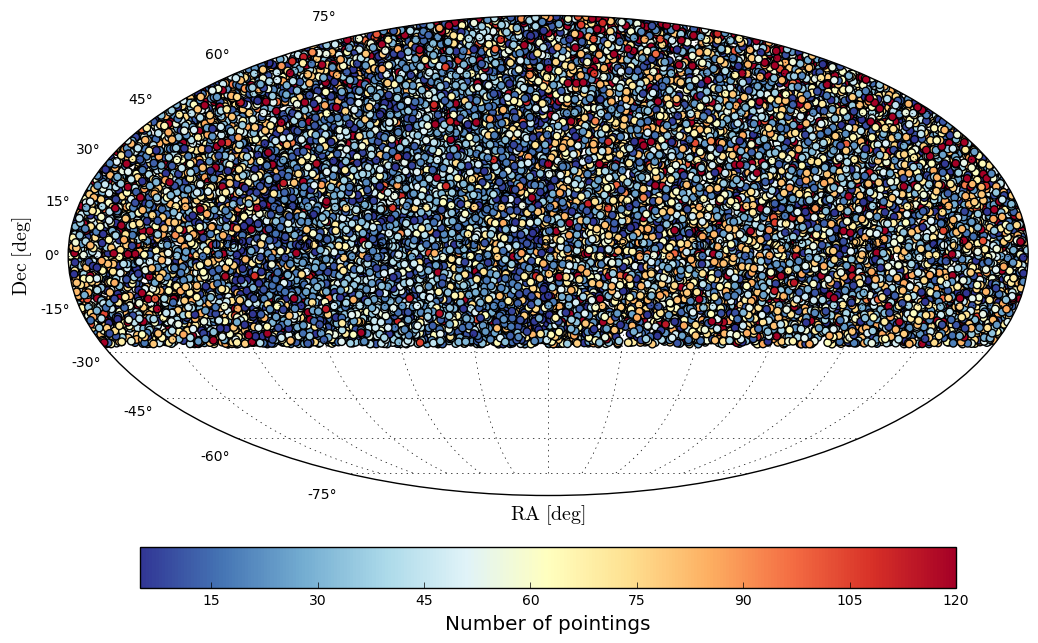

In [12]:
idx = lcs.meta['idx_orig']
n_obs = np.zeros(survey.generator.ntransient)
n_obs[idx] = np.array([len(a) for a in lcs])

survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of pointings", mask=idx)
print 'SNe pointed to: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

SNe detected: 15156 out of 54829


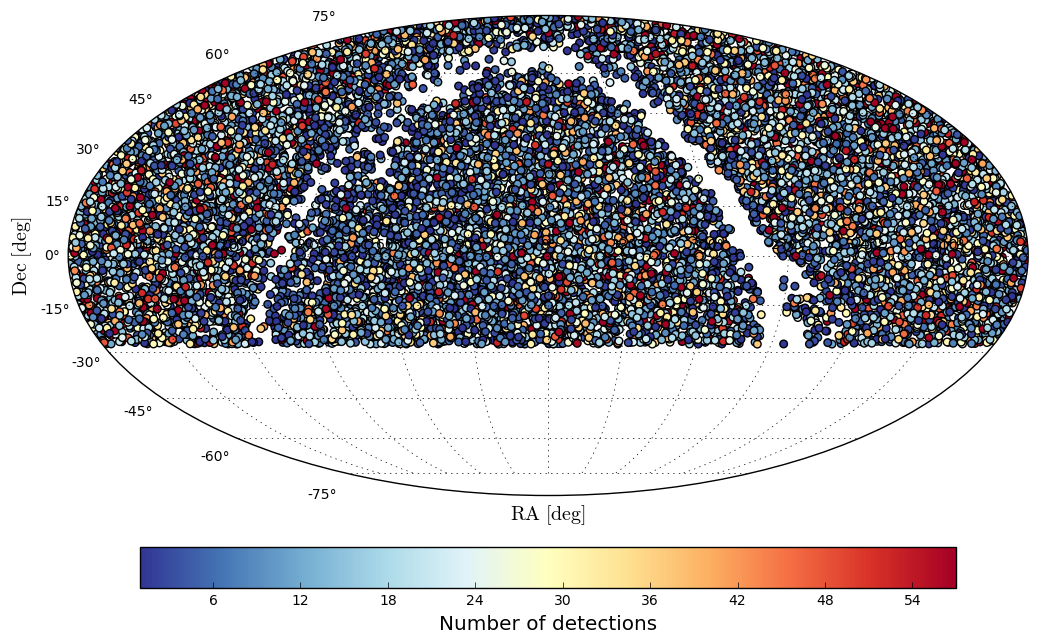

In [13]:
t_exp = -20

lcs_det = [lc[lc['flux']/lc['fluxerr'] > 5] for lc in lcs]
lcs_det = [lc[lc['time'] > t_exp*(1+lc.meta['z']) + lc.meta['t0']] for lc in lcs_det]

idx_det = lcs.meta['idx_orig'][np.array([len(lc) > 0 for lc in lcs_det])]
n_det = np.zeros(survey.generator.ntransient)
lcs_det = [lc for lc in lcs_det if len(lc) > 0]
n_det[idx_det] = np.array([len(a) for a in lcs_det])

survey.generator.show_skycoverage(cscale=n_det, cblabel="Number of detections", mask=idx_det)
print 'SNe detected: %i out of %i'%(np.sum(n_det > 0), survey.generator.ntransient)

In [14]:
z = np.array([lc.meta['z'] for lc in lcs_det])
p_i = np.array([lc['time'].min() - lc.meta['t0'] for lc in lcs_det])
p_e = np.array([lc['time'].max() - lc.meta['t0'] for lc in lcs_det])

The two last figures show how early the SNe are detected and at what redshift.

SNe found before peak: 11581


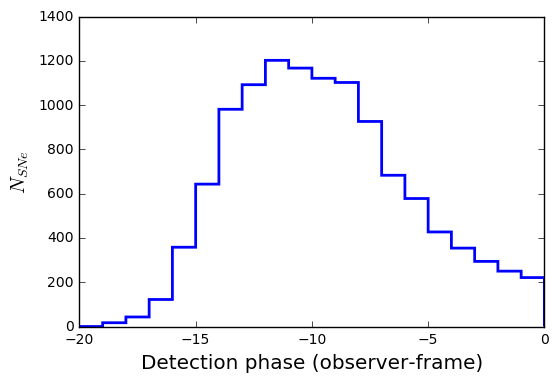

In [15]:
plt.hist(p_i, lw=2, histtype='step', range=(-20,0), bins=20)
print 'SNe found before peak:', np.sum(p_i < 0)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')

SNe found 14 observer-frame days before peak: 1183
Local SNe (z < 0.1) found 14 observer-frame days before peak: 754


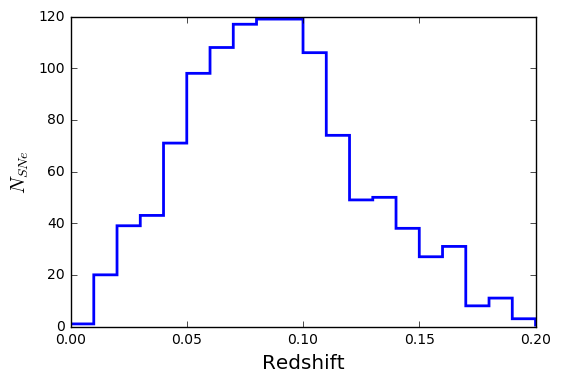

In [16]:
p_lim = -14
n = np.array([len(lc) for lc in lcs_det])
snr_max = np.array([max(lc['flux']/lc['fluxerr']) for lc in lcs_det])
plt.hist(z[(p_i < p_lim) & (snr_max >= 10)], lw=2, histtype='step', range=(0,0.2),bins=20)
print 'SNe found 14 observer-frame days before peak:', np.sum(p_i < p_lim) 
print 'Local SNe (z < 0.1) found 14 observer-frame days before peak:', np.sum((p_i < p_lim) & (z < 0.1))
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
_ = plt.xlim((0, 0.2))